In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

seed = 55
np.random.seed(seed)

## Dataset description

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. You are asked to predict an integer classification for the forest cover type. The seven types are:

1 - Spruce/Fir
2 - Lodgepole Pine
3 - Ponderosa Pine
4 - Cottonwood/Willow
5 - Aspen
6 - Douglas-fir
7 - Krummholz

The training set (15120 observations) contains both features and the Cover_Type. The test set contains only the features. You must predict the Cover_Type for every row in the test set (565892 observations).

Data Fields

Elevation - Elevation in meters

Aspect - Aspect in degrees azimuth

Slope - Slope in degrees

Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features

Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features

Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway

Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice

Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice

Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points

Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation


## Data inspection


In [2]:
train_data = pd.read_csv("/kaggle/input/forest-cover-type-prediction/train.csv")
test_data = pd.read_csv("/kaggle/input/forest-cover-type-prediction/test.csv")
train_data.drop(columns=['Id'], inplace=True)
test_data.drop(columns=['Id'], inplace=True)
train_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
train_data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Wilderness_Area1                    15120 non-null  int64
 11  Wilderness_Area2                    15120 non-null  int64
 12  Wild

In [5]:
# Check target values distribution
train_data.Cover_Type.value_counts()

Cover_Type
5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: count, dtype: int64

In [6]:
dist = [c for c in train_data.columns if "Distance" in c]
hillsh = [c for c in train_data.columns if "Hillshade" in c]
wild = [c for c in train_data.columns if "Wild" in c]
soil = [c for c in train_data.columns if "Soil" in c]

# These are in onehot encoded format:
wild_soil = [c for c in train_data.columns if c.startswith('Wild') or c.startswith('Soil')]
train_data[wild_soil].describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,...,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,...,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


It looks like all features are numerical, except soil type and wilderness area features which are in one-hot encoded format.
The target distribution is completely balanced with equal data points for every class, and we dont have to clean the data for missing values either.

First I am going to revert the one-hot encoded format features in order to make some further data exploration easier.

In [7]:
def one_hot_to_label(df, ohe_columns, new_name="encoded_feature"):
    """ Converts onehot encoded columns into a single label encoded column."""

    # Convert one-hot encoding to categorical labels
    df[new_name] = df[ohe_columns].idxmax(axis=1)
    # Remove the one-hot prefix from the category names
    df[new_name] = df[new_name].apply(lambda x: x.split('_')[-1])
    # Label encode the new column
    le = LabelEncoder()
    df[new_name] = le.fit_transform(df[new_name])
    # Drop the original one-hot columns
    df.drop(columns=ohe_columns, inplace=True)

    return df

In [8]:
train_data = one_hot_to_label(train_data, wild, new_name="Wild_area")
train_data = one_hot_to_label(train_data, soil, new_name="Soil_type")
test_data = one_hot_to_label(test_data, wild, new_name="Wild_area")
test_data = one_hot_to_label(test_data, soil, new_name="Soil_type")

cont_feats = [c for c in train_data.columns if c not in ['Cover_Type','Soil_type','Wild_area']]
cat_feats = ['Soil_type','Wild_area']
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           15120 non-null  int64
 1   Aspect                              15120 non-null  int64
 2   Slope                               15120 non-null  int64
 3   Horizontal_Distance_To_Hydrology    15120 non-null  int64
 4   Vertical_Distance_To_Hydrology      15120 non-null  int64
 5   Horizontal_Distance_To_Roadways     15120 non-null  int64
 6   Hillshade_9am                       15120 non-null  int64
 7   Hillshade_Noon                      15120 non-null  int64
 8   Hillshade_3pm                       15120 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  15120 non-null  int64
 10  Cover_Type                          15120 non-null  int64
 11  Wild_area                           15120 non-null  int64
 12  Soil

In [9]:
print(f"Wild_area value counts: {train_data.Wild_area.value_counts()}")
print(f"Soil_type value counts: {train_data.Soil_type.value_counts()}")

Wild_area value counts: Wild_area
2    6349
3    4675
0    3597
1     499
Name: count, dtype: int64
Soil_type value counts: Soil_type
1     2142
20    1291
21     962
32     843
14     757
30     728
22     725
24     690
31     657
35     650
10     623
25     616
7      612
4      476
33     459
2      406
0      355
13     345
23     332
15     257
3      227
5      169
34     165
11     139
6      114
27     102
8       60
17      54
9       46
29      34
26      22
12      16
18      15
37      10
28      10
19       9
36       1
16       1
Name: count, dtype: int64


One problem with Soil type is that some classes have very weak representation. This might be problematic for the model, so I decided to merge these classes into 1.

In [10]:
# Merging low value count categories
th = 50
new_val = 60 # for now setting it to an outside value, this will not matter when data is one-hot encoded
soil_type_counts = train_data.Soil_type.value_counts()
rare_soils = soil_type_counts[soil_type_counts < th].index

train_data["Soil_type"] = train_data["Soil_type"].replace(rare_soils, new_val)
test_data["Soil_type"] = test_data["Soil_type"].replace(rare_soils, new_val)

In [11]:
print("Unique values on train:")
for f in train_data.columns:
    print(f"{f} distinct values: {train_data[f'{f}'].nunique()}")
    
print("\nUnique values on test:")
for f in test_data.columns:
    print(f"{f} distinct values: {test_data[f'{f}'].nunique()}")

Unique values on train:
Elevation distinct values: 1665
Aspect distinct values: 361
Slope distinct values: 52
Horizontal_Distance_To_Hydrology distinct values: 400
Vertical_Distance_To_Hydrology distinct values: 423
Horizontal_Distance_To_Roadways distinct values: 3250
Hillshade_9am distinct values: 176
Hillshade_Noon distinct values: 141
Hillshade_3pm distinct values: 247
Horizontal_Distance_To_Fire_Points distinct values: 2710
Cover_Type distinct values: 7
Wild_area distinct values: 4
Soil_type distinct values: 29

Unique values on test:
Elevation distinct values: 1974
Aspect distinct values: 361
Slope distinct values: 67
Horizontal_Distance_To_Hydrology distinct values: 551
Vertical_Distance_To_Hydrology distinct values: 700
Horizontal_Distance_To_Roadways distinct values: 5785
Hillshade_9am distinct values: 207
Hillshade_Noon distinct values: 185
Hillshade_3pm distinct values: 255
Horizontal_Distance_To_Fire_Points distinct values: 5826
Wild_area distinct values: 4
Soil_type distin

Even though Slope has a low amount of distinct values, there is a logical ordering in the feature, so it must remain a continuous variable.
The only true categoricals are Wild_area and Soil_type. However there are differences in the number of classes for train/test in Soil type.

In [12]:
# What categs are missing from train for Soil_type that are present in test
train_unq = train_data.Soil_type.unique()
missing = [m for m in test_data.Soil_type.unique() if m not in train_unq]
missing 

[38, 39]

This means the model wont generalize well on the test data if we dont have these classes at training time. So I think the best possible solution is to merge these categories to a 'unknown' category (new_val). We could also drop these records, but that might have issues with submission.

In [13]:
test_data["Soil_type"] = test_data["Soil_type"].replace(missing, new_val)

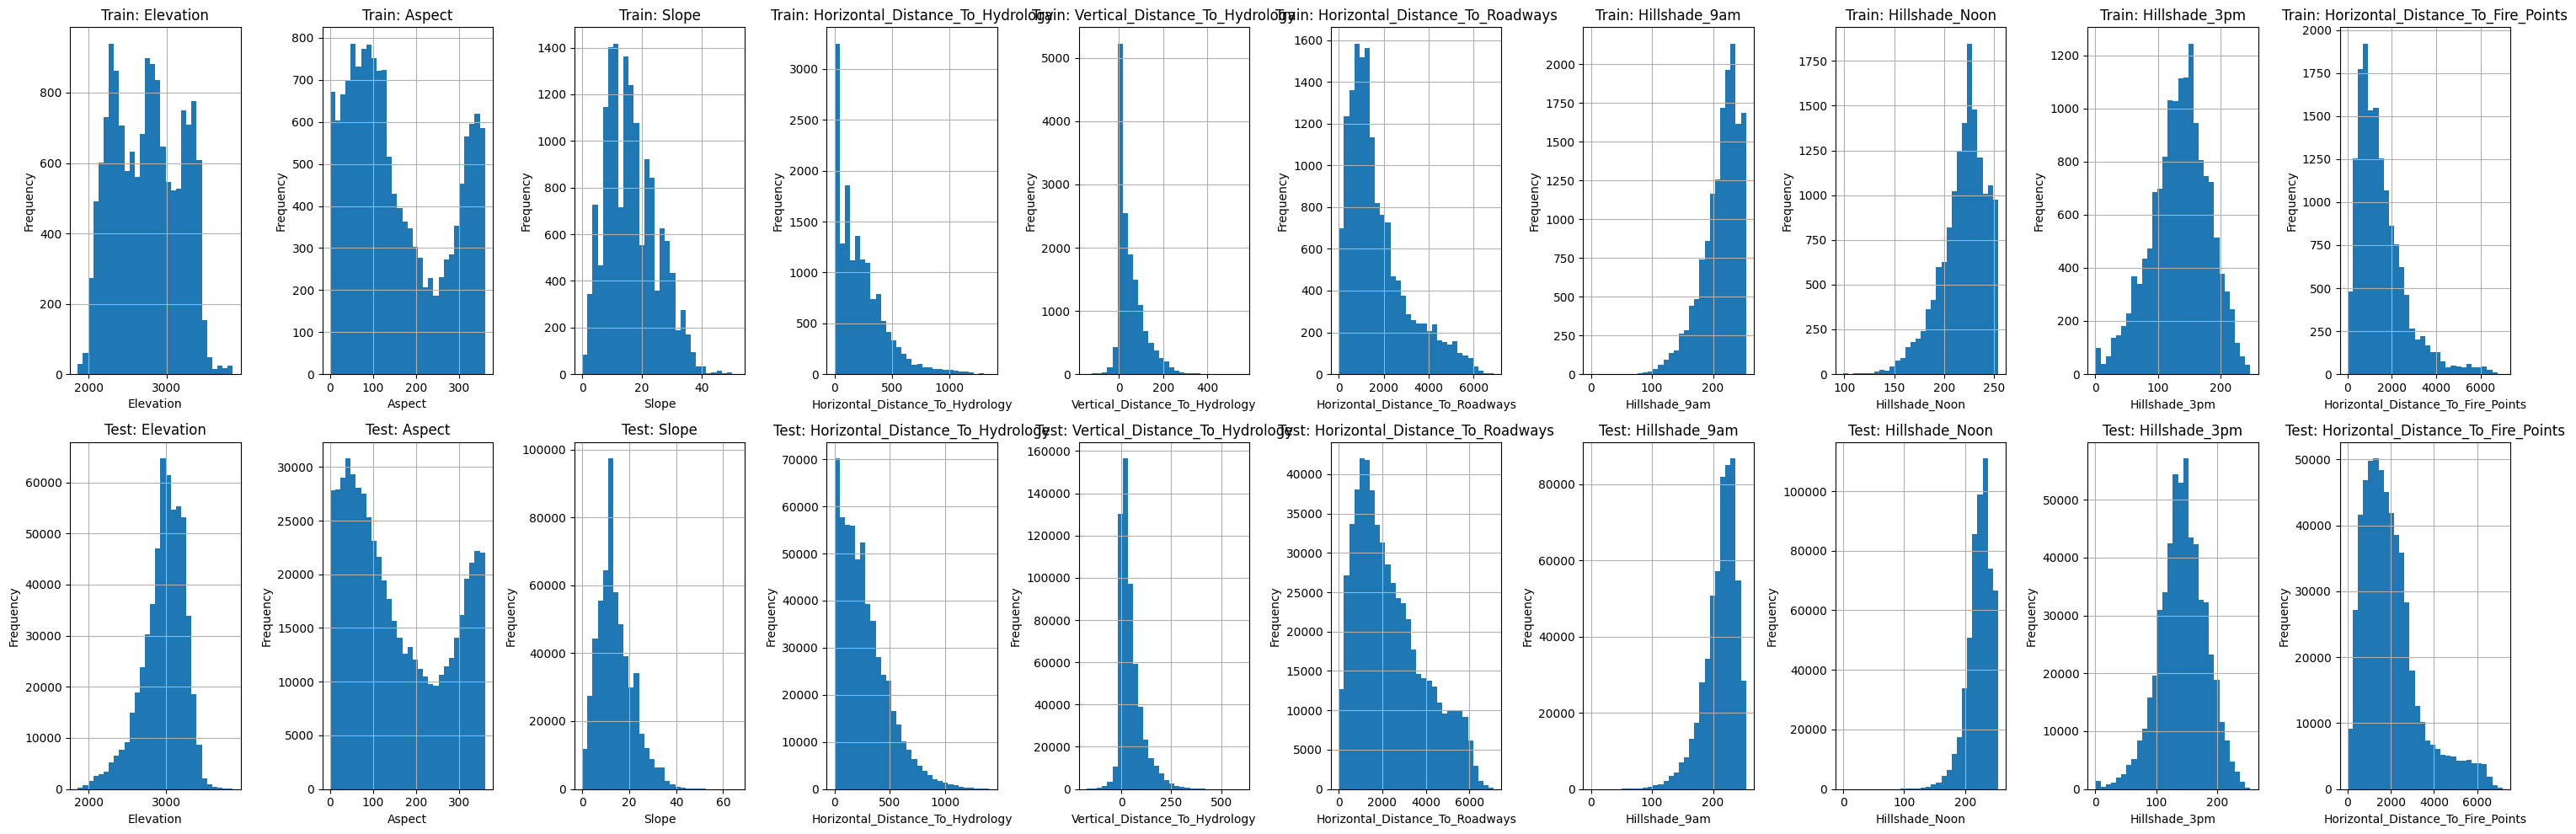

In [14]:
# Inspect constant feature distribution
tr = train_data.copy()
tr.drop(columns=["Cover_Type"],axis=1)
plt.figure(figsize=(30, 10))

for i in cont_feats:
    plt.subplot(2, len(cont_feats), cont_feats.index(i) + 1)
    tr[i].hist(bins=30)
    plt.title(f'Train: {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')

    plt.subplot(2, len(cont_feats), len(cont_feats) + cont_feats.index(i) + 1)
    test_data[i].hist(bins=30)
    plt.title(f'Test: {i}')
    plt.xlabel(i)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

By checking the continuous feature's distribution, we can see that the test data's Elevation is very skewed, while on the train side it is more like uniform. Based on this we could experiment with sample weighting on the modelling part.

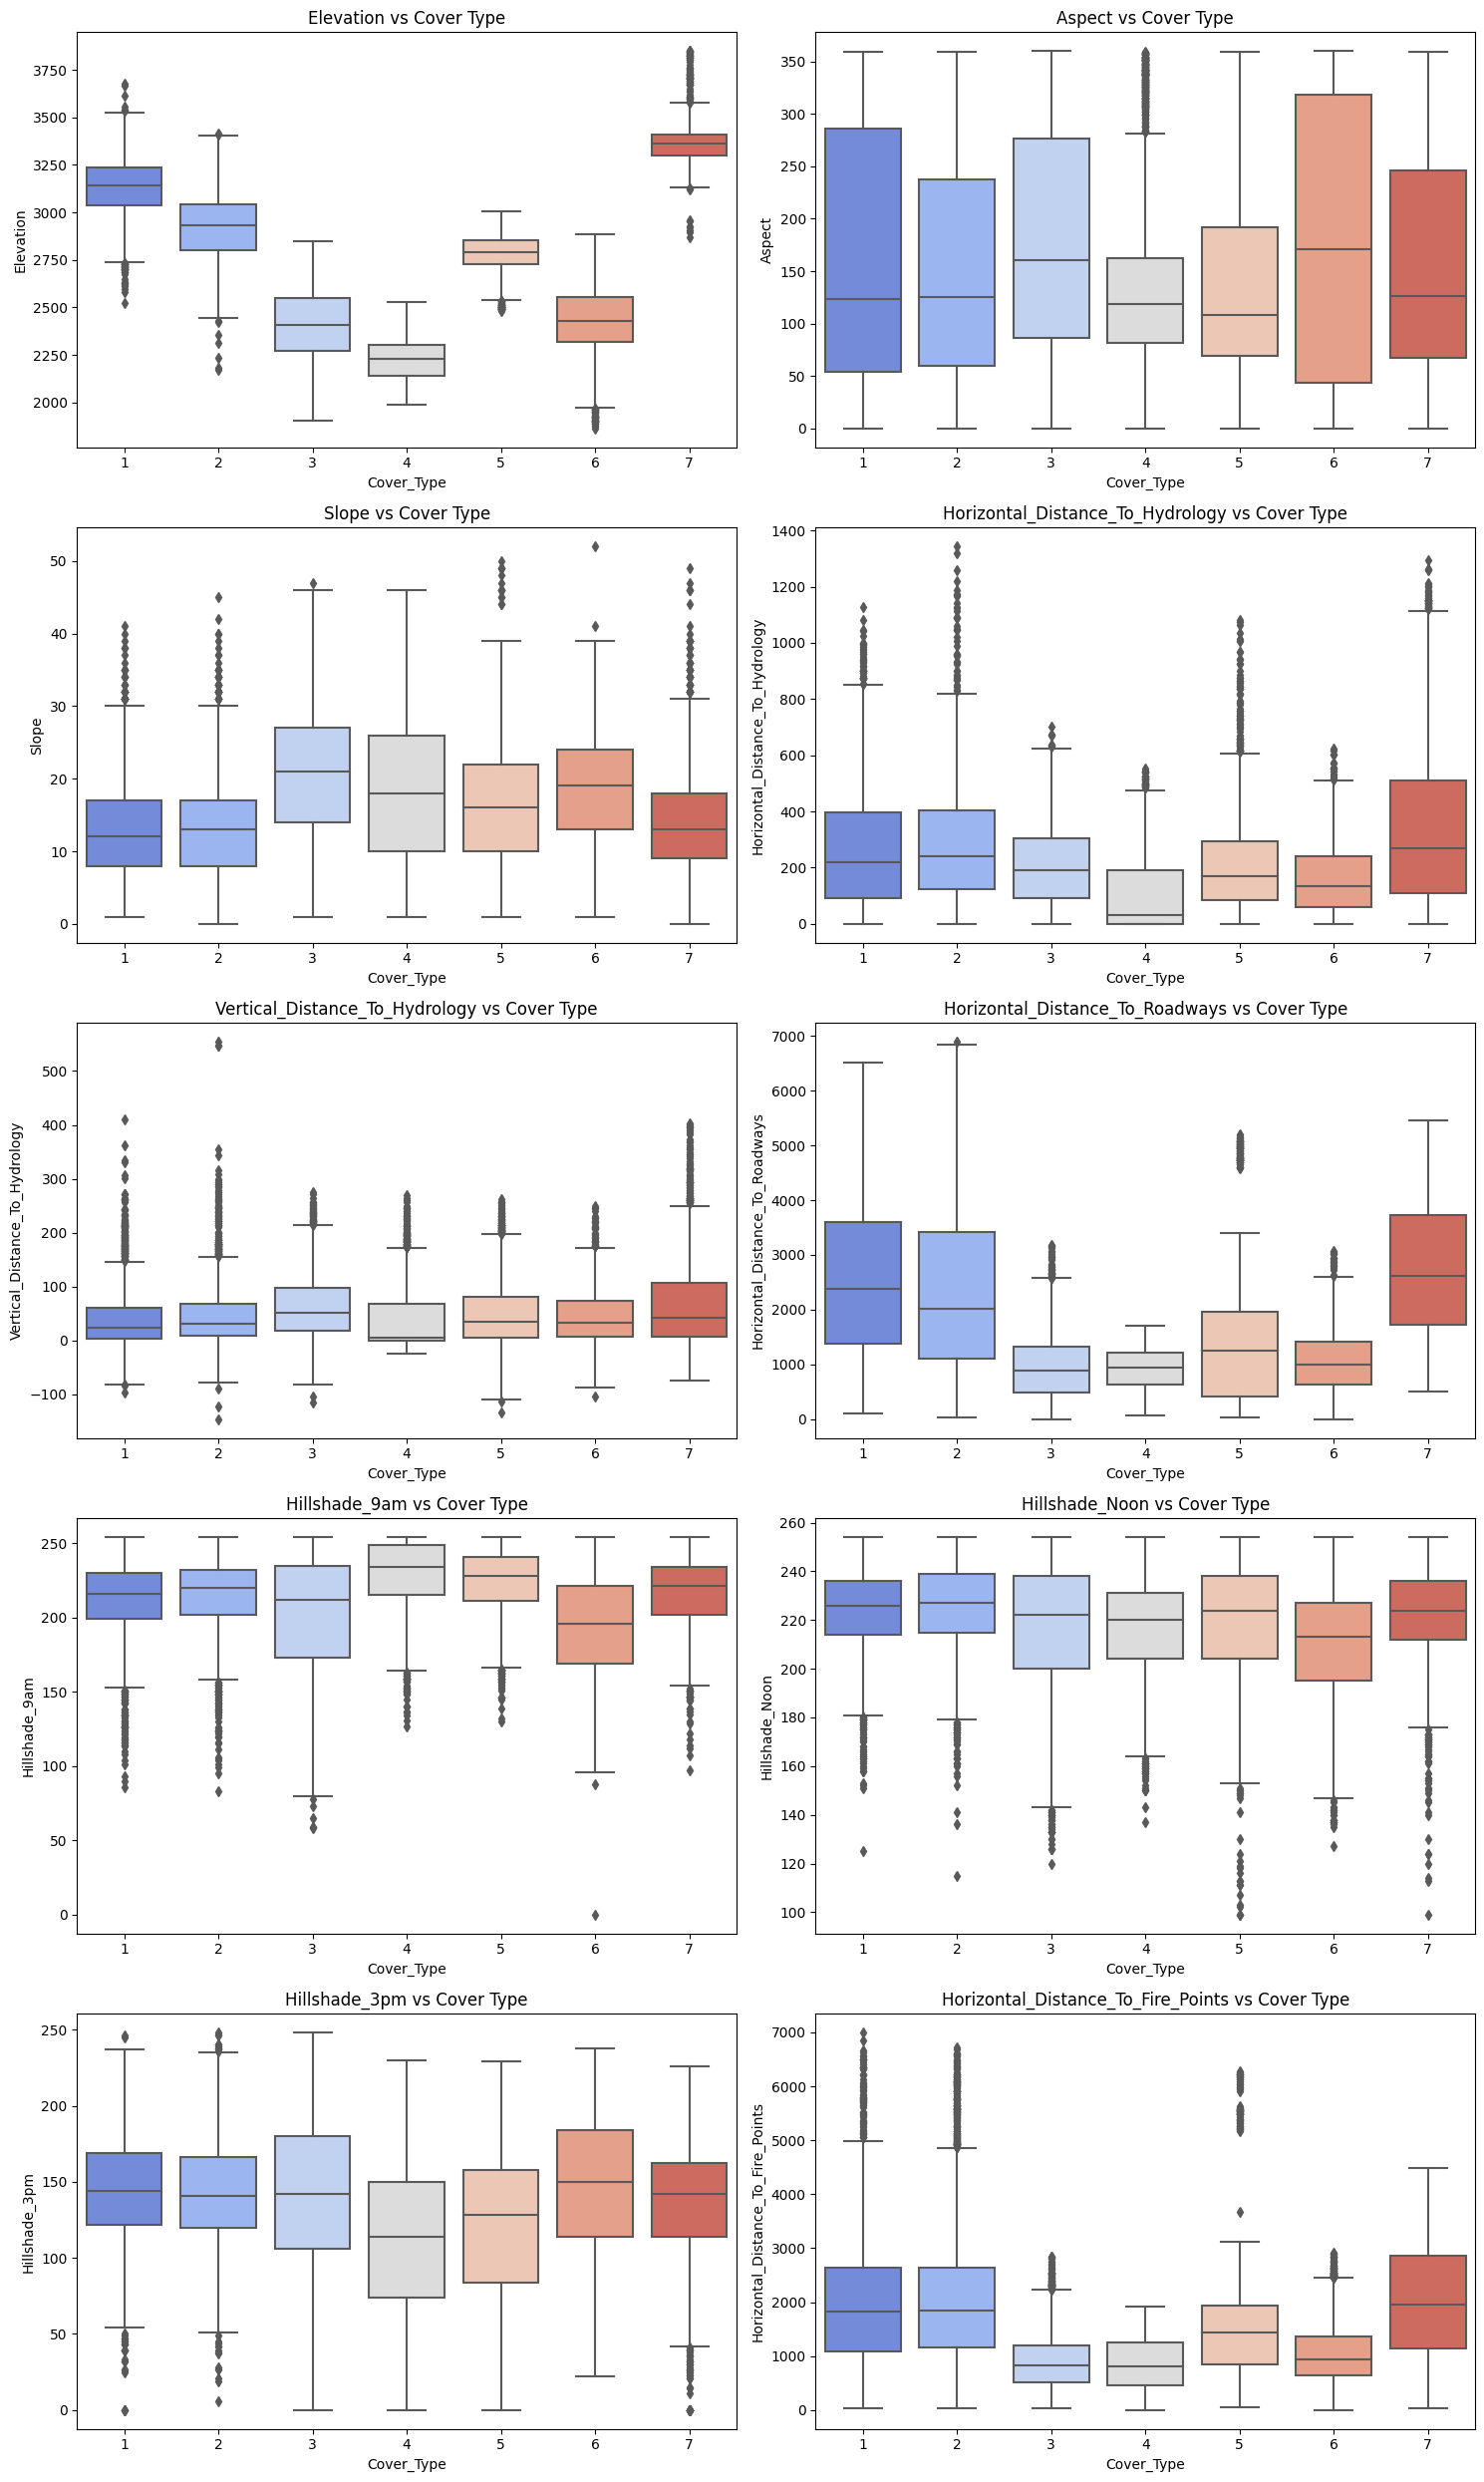

In [15]:
# Boxplots to show feature distribution variations for continuous numericals by target

plt.figure(figsize=(15, 25))
for i, col in enumerate(cont_feats, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=train_data["Cover_Type"], y=train_data[col], palette="coolwarm")
    plt.title(f"{col} vs Cover Type")
plt.tight_layout()
plt.show()

Main conclusions:
- Elevatoin - Cover Type:
    - Shows how well separated the different tree covers are by elevation (also notable that all data are above 2000 m, so this is a mountainous area)
- Aspect - Cover Type:
    - Aspect for cover type 4. is interesting, as it has many outliers with a dense appearance.
    - It does not have any trend, so this feature alone might not be a good predictor.
- Slope - Cover Type:
    - Looks fairly balanced by distribution. Its outliers are more seperable. They indicate extreme terrain surfaces.
- Horizontal_Distance_To_Hydrology - Cover_Type:
    - 3,4,6 shows that they are vegetations highly rely on water, especially 4 which has a low median value.
- Vertical_Distance_To_Hydrology - Cover_Type:
    - The appeareance is similar to Horizontal distance.
    - All categories have some-many outliers, with tight interquartile ranges.
- Horizontal_Distance_To_Roadways - Cover_Type:
    - Here we can see pretty much the same trend as we had with Horizontal_Distance_To_Hydrology. Cover types are highly influenced by human transport (3,4,5,6).
- Hillshade features:
    - They have a range of 0-255. If value is low, the C. type accepts more darkness, while high value indicates more illumination, so cover types in this region requires more sunlight.
- Horizontal_Distance_To_Fire_Points - Cover Type:
    - Same trend as other distance features
    - These 'distance' features could make to a good combined feature in feature engineering.

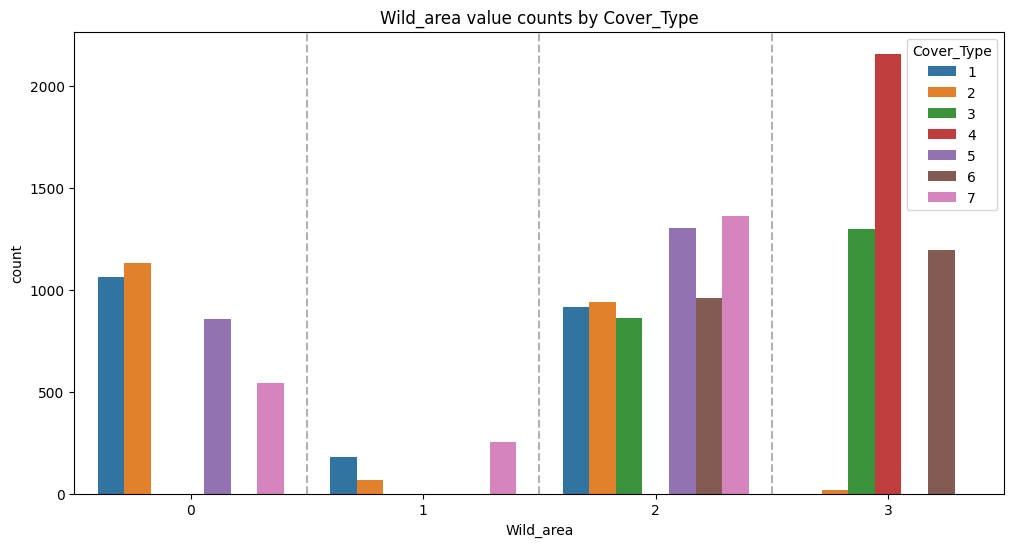

In [16]:
# Count plot to show feature counts of categoricals
# (to explore the cat_feature - target relationship)

plt.figure(figsize=(12, 6))
sns.countplot(x=train_data['Wild_area'], hue=train_data['Cover_Type'])
plt.title("Wild_area value counts by Cover_Type")
for i in range(3):
    plt.axvline(x=i + 0.5, color='black', linestyle='--', alpha=0.3)
plt.show()
# showing only Wild_area, since Soil_type has too many categories

This plot indicates that Wilderness areas feature is also a valuable predictor, since the certain cover types are well separable.

## Filtering outliers

This is an experimental part. Removing too many records could have a negative effect. I will try to calibrate this with some tests.

In [17]:
from scipy.stats import zscore

def IQR_filter(df, feature, w=1.5, remove=False):
    """ Filter out the outliers for given feature. Parameter 'w' is a multiplier that can be set higher for skewed data. 
        Works well for asymmetric distributions.
    """
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1 # interquartile range
    lower_bound = Q1 - w * IQR
    upper_bound = Q3 + w * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    if remove:
        return df.drop(outliers.index)
    else:
        return len(outliers)

def Z_score_filter(df, feature, threshold=3, remove=False):
    """ Filter out the outliers using Z-score method based on a threshold. 
        Works well for normal distributions.
    """
    dfc = df.copy()
    dfc[f'Z_{feature}'] = zscore(dfc[feature])
    
    # Detect outliers with threshold
    outliers = dfc[(dfc[f'Z_{feature}'].abs() > threshold)]
    dfc.drop(columns=[f'Z_{feature}'], inplace=True)

    if remove:
        return dfc.drop(outliers.index)
    else:
        return len(outliers)

w = 2
z_th = 2

for col in cont_feats:
    print(f"IQR filter ({col}): {IQR_filter(train_data, col, w)} outliers")
    print(f"Z-score filter ({col}): {Z_score_filter(train_data, col, z_th)} outliers");print()


IQR filter (Elevation): 0 outliers
Z-score filter (Elevation): 96 outliers

IQR filter (Aspect): 0 outliers
Z-score filter (Aspect): 0 outliers

IQR filter (Slope): 11 outliers
Z-score filter (Slope): 499 outliers

IQR filter (Horizontal_Distance_To_Hydrology): 285 outliers
Z-score filter (Horizontal_Distance_To_Hydrology): 701 outliers

IQR filter (Vertical_Distance_To_Hydrology): 257 outliers
Z-score filter (Vertical_Distance_To_Hydrology): 840 outliers

IQR filter (Horizontal_Distance_To_Roadways): 330 outliers
Z-score filter (Horizontal_Distance_To_Roadways): 944 outliers

IQR filter (Hillshade_9am): 126 outliers
Z-score filter (Hillshade_9am): 757 outliers

IQR filter (Hillshade_Noon): 129 outliers
Z-score filter (Hillshade_Noon): 714 outliers

IQR filter (Hillshade_3pm): 0 outliers
Z-score filter (Hillshade_3pm): 698 outliers

IQR filter (Horizontal_Distance_To_Fire_Points): 381 outliers
Z-score filter (Horizontal_Distance_To_Fire_Points): 733 outliers



In [18]:
# IQR gave the best performance with w = 2

print(f"Records before outlier filter: {len(train_data)}")
bef_train_data = len(train_data)

for col in cont_feats:
    train_data = IQR_filter(train_data, col, w, remove=True)
    # train_data = Z_score_filter(train_data, col, z_th, remove=True)

diff = bef_train_data - len(train_data)
print(f"Records after outlier filter: {len(train_data)} (-{diff})")
train_data = train_data.reset_index(drop=True)

Records before outlier filter: 15120
Records after outlier filter: 13710 (-1410)


In [19]:
# For checking out the change of outliers

# plt.figure(figsize=(15, 25))
# for i, col in enumerate(cont_feats, 1):
#     plt.subplot(5, 2, i)
#     sns.boxplot(x=train_data["Cover_Type"], y=train_data[col], palette="coolwarm")
#     plt.title(f"{col} vs Cover Type")
# plt.tight_layout()
# plt.show()

## Correlations

- Correlation matrix to explore feature relationships
- Reduce multicollinearity
- Further assess feature correlations with scatter plots

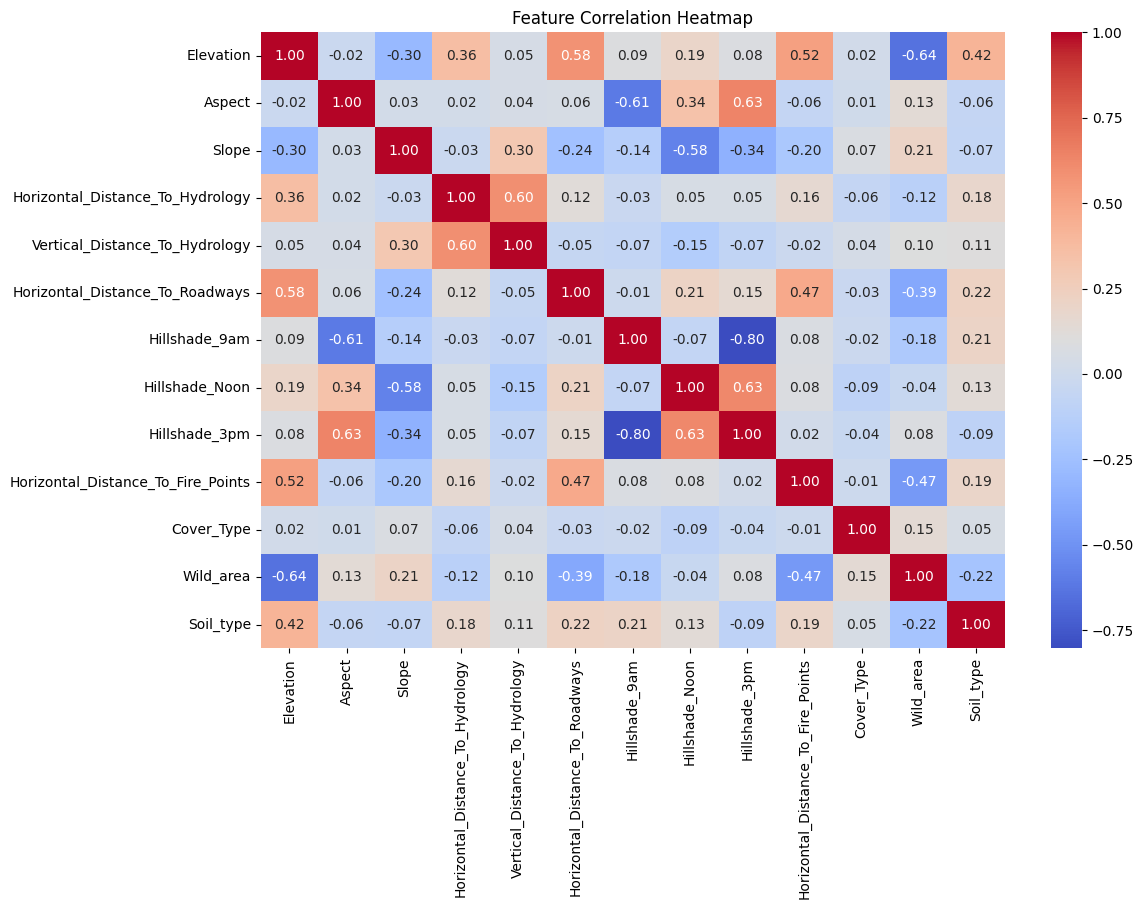

In [20]:
# Correlation matrix between features
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Some insights from correlations:

Hillshade_9am - Hillshade_3pm : -0.80
- This inverse relationship is understandable, as the sun changes its angles throughout the day.

Hillshade_Noon - Hillshade_3pm : 0.63
- Also understandable as the sun are high up at noon and 3pm as well. So usually the same values applies for most of the samples.

Horizontal_Distance_To_Hydrology - Vertical_Distance_To_Hydrology : 0.60
- Rivers are usually in valleys, so if we are far from a river horizontally, we are probably at a higher elevation.

Horizontal_Distance_To_Roadways - Elevation : 0.58
- Higher elevations have fewer roads, because roads are mostly built in lower, flat areas (-0.30 with Slope).

Wild_area - Elevation : -0.64
- Relatively high negative correlation. Some high elevations are rocky or unsuitable for dense forests.

Horizontal_Distance_To_Fire_Points - Wild_area : -0.47
- This relationship could be slightly inverse, bacause dense forests are usually not appearing in wildfire locations.

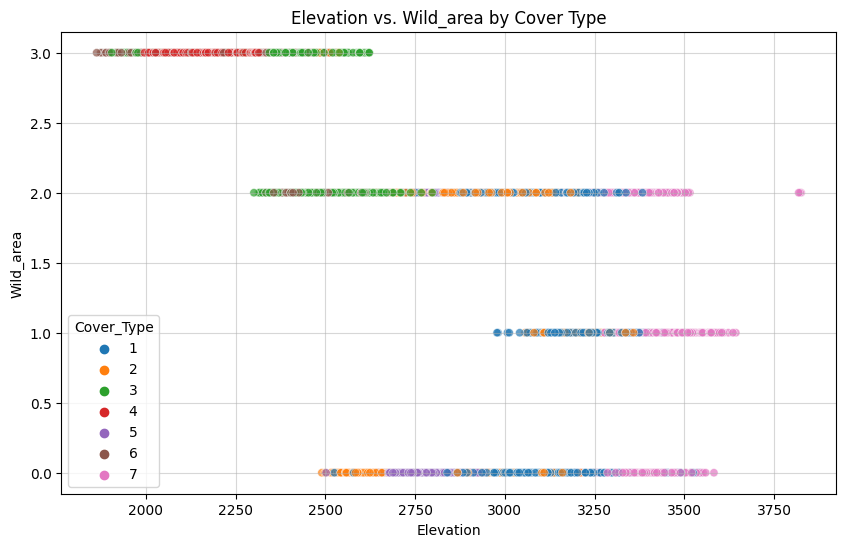

In [21]:
# Checking out some of the correlating feature pairs in a scatterplot
# (to inspect desesion boundaries in the feature space)

# Wild area shows significat correlation with several features, so first I observe these

x_feat = "Elevation"
y_feat = "Wild_area"
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x=x_feat, y=y_feat, hue="Cover_Type", palette="tab10", alpha=0.7)
plt.title(f"{x_feat} vs. {y_feat} by Cover Type")
plt.grid(alpha=0.5)
plt.show()

This scatter plot seems to provide useful informations for all 3 features. We can divide the Elevation into Elevation categories in the feature engineering section.

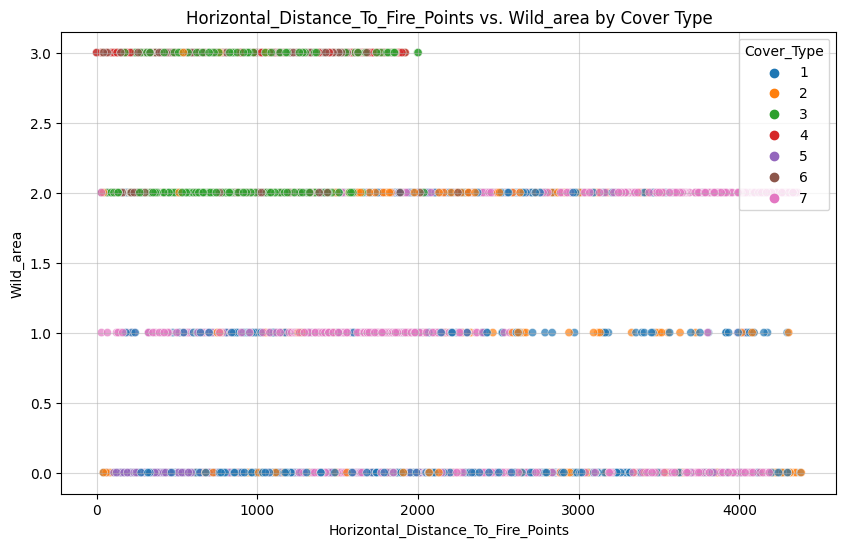

In [22]:
x_feat = "Horizontal_Distance_To_Fire_Points"
y_feat = "Wild_area"

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x=x_feat, y=y_feat, hue="Cover_Type", palette="tab10", alpha=0.7)
plt.title(f"{x_feat} vs. {y_feat} by Cover Type")
plt.grid(alpha=0.5)
plt.show()

This could also make a good feature in feature engineering, although it is less seperable by taking the target into the picture. It could help classify cover type 3. as it only appears close to fire points (and only found in Wild_area 2 and 3).

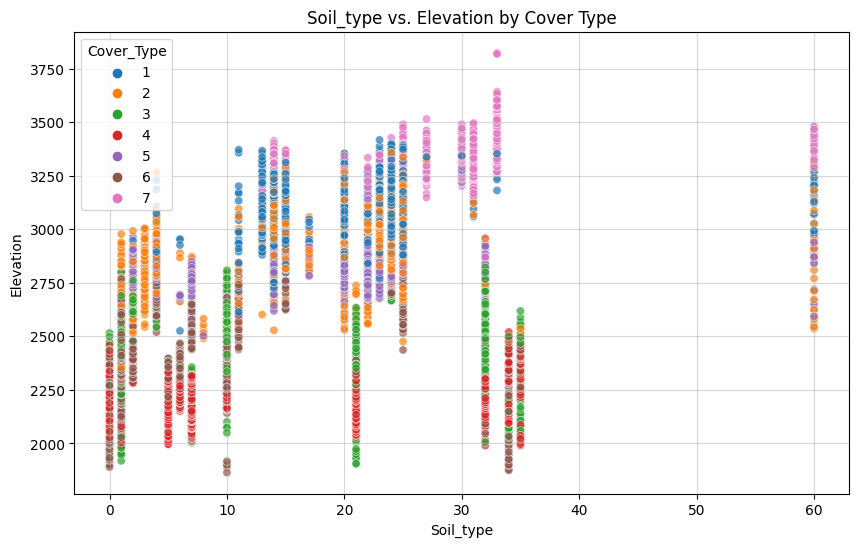

In [23]:
x_feat = "Soil_type"
y_feat = "Elevation"

plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x=x_feat, y=y_feat, hue="Cover_Type", palette="tab10", alpha=0.7)
plt.title(f"{x_feat} vs. {y_feat} by Cover Type")
plt.grid(alpha=0.5)
plt.show()

From this we can see that certain Soil_types only appearing in for certain Cover_Types, and they also appearing in a limited range of Elevation. This Could also be exploited with a good interaction/combine feature.


## Feature selection

(exploring feature - target relationship)

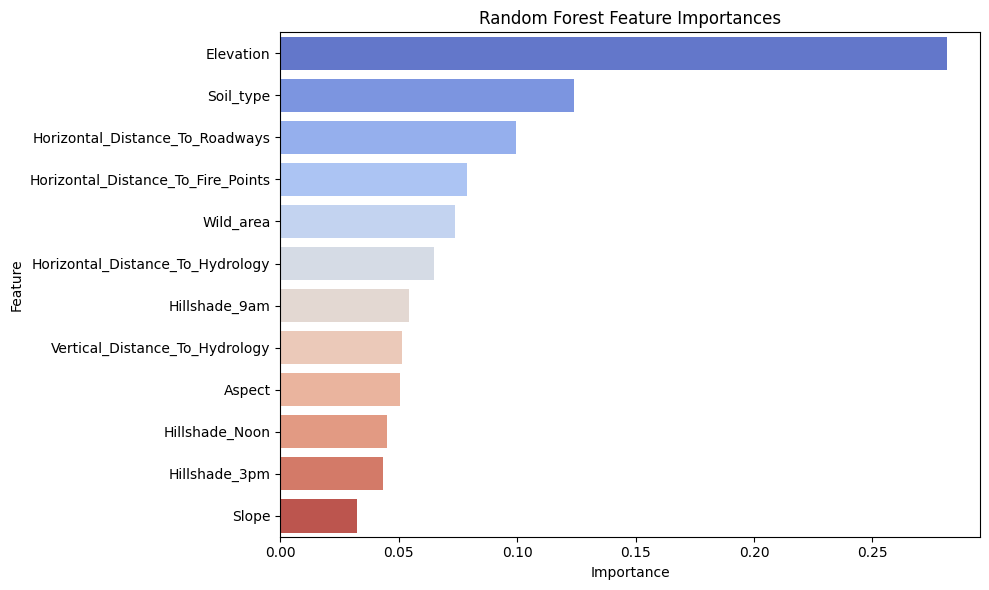

In [24]:
# Observing feature importances that might recognise the important predictors for classification
# (feature importance = how often a feature is used in decision splits in tree models)

X = train_data.drop(columns=["Cover_Type"])
y = train_data["Cover_Type"]

model = RandomForestClassifier(n_estimators=200, random_state=seed)
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
fi_df = pd.DataFrame({"Feature": X.columns[indices], "Importance": importances[indices]})

plt.figure(figsize=(10, 6))
sns.barplot(x=fi_df["Importance"], y=fi_df["Feature"], palette="coolwarm")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

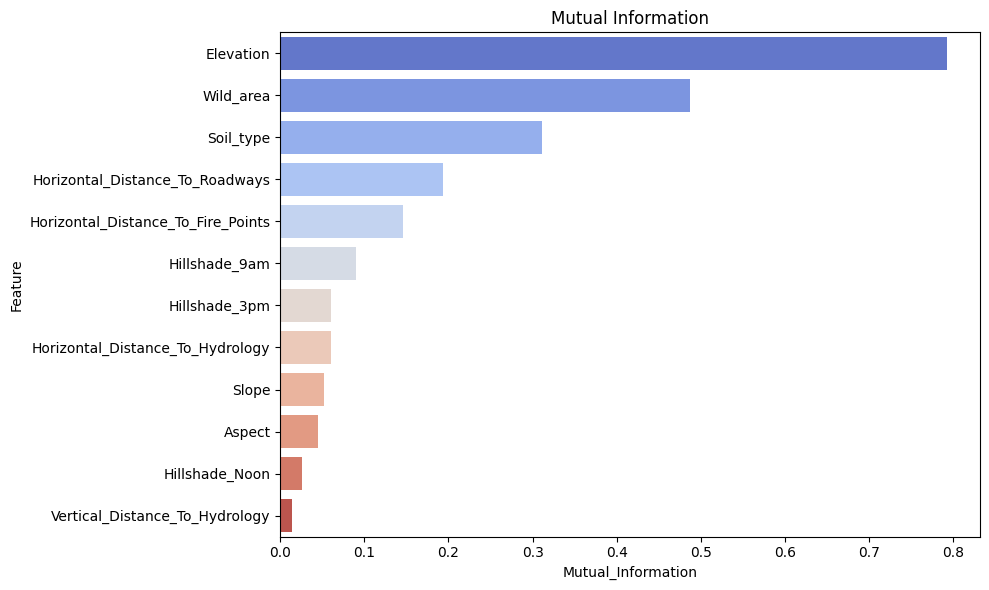

In [25]:
# Mutual Information
# (How much knowing a feature reduces uncertainty about the target)
# - Measures how much information one variable provides about another
# - Works well with categorical and numerical features
# - Captures nonlinear dependencies

X = train_data.drop(columns=["Cover_Type"])
y = train_data["Cover_Type"]

mi = mutual_info_classif(X, y, discrete_features=False)
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual_Information": mi})
mi_df = mi_df.sort_values("Mutual_Information", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_df['Mutual_Information'], y=mi_df['Feature'], palette="coolwarm")
plt.title("Mutual Information")
plt.tight_layout()
plt.show()

So maybe both FI and MI scores matters, therefore we could make a combined ranking from them.

In [26]:
from sklearn.preprocessing import MinMaxScaler

# First normalize them to have the same scale
scaler = MinMaxScaler()
fi_df["Normalized_FI"] = scaler.fit_transform(fi_df["Importance"].values.reshape(-1, 1))
mi_df["Normalized_MI"] = scaler.fit_transform(mi_df["Mutual_Information"].values.reshape(-1, 1))

# Merge dfs
combined_df = fi_df.set_index("Feature").join(mi_df.set_index("Feature")).drop(["Importance","Mutual_Information"],axis=1)

# Create a combined score
combined_df["Combined_Score"] = combined_df["Normalized_FI"] + combined_df["Normalized_MI"]
combined_df = combined_df.sort_values("Combined_Score", ascending=False)
combined_df

,Normalized_FI,Normalized_MI,Combined_Score
Feature,,,
Elevation,1.000000,1.000000,2.000000
Wild_area,0.166225,0.608348,0.774573
Soil_type,0.368233,0.382319,0.750552
Horizontal_Distance_To_Roadways,0.270363,0.231630,0.501993
Horizontal_Distance_To_Fire_Points,0.186412,0.169601,0.356013
Horizontal_Distance_To_Hydrology,0.131229,0.059473,0.190701
Hillshade_9am,0.088193,0.098163,0.186356
Aspect,0.073725,0.040093,0.113818
Hillshade_3pm,0.044260,0.060617,0.104878


Observations:
- Soil_type and Elevation are usually important factors if we think about vegetations. They are also related to each other.
- Wilderness_area's importance is also make sense, as it is closely related to the target.
- Even though Slope (for example) not have a direct connection with the target, it still could be useful when combined with others.

## Feature Engineering

First I experiment with sample weighting in order to balance the distribution difference shown by elevation data.

In [27]:
from scipy.stats import gaussian_kde

# The goal here is to adjust the importance of different elevation ranges in training to better match the test distribution.
# I downweight the overrepresented regions in training (like 0-2500) and upweight others (2700-3300).
# Therefore I calculate the KDE ratio and normalize it.

# Estimate density for train and test
kde_train = gaussian_kde(train_data['Elevation'])
kde_test = gaussian_kde(test_data['Elevation'])

# Compute weights as test density / train density ratio
kde_ratio = kde_test(train_data['Elevation']) / kde_train(train_data['Elevation'])

# Normalize KDE ratio
sample_weights = kde_ratio / np.mean(kde_ratio)

Based on the exploratory analysis there are observed feature relationships that could be even more effective if we apply some sort of transformation or interaction on them. 

In [28]:
# 1. Distance features combined
# They have similar distributions per target on boxplots. So it makes sense to create a combined feature.
train_data['H_distance_combined'] = (train_data['Horizontal_Distance_To_Roadways'] * 0.5) 
+ (train_data['Horizontal_Distance_To_Fire_Points'] * 0.4) 
+ (train_data['Horizontal_Distance_To_Hydrology'] * 0.3)
test_data['H_distance_combined'] = (test_data['Horizontal_Distance_To_Roadways'] * 0.5) 
+ (test_data['Horizontal_Distance_To_Fire_Points'] * 0.4) 
+ (test_data['Horizontal_Distance_To_Hydrology'] * 0.3)
# (weights are based on combined feature importance)

# 2. Semantically related features
# Combine these two, since they are closely related
train_data['Slope_elev'] = train_data['Slope'] * train_data['Elevation']
test_data['Slope_elev'] = test_data['Slope'] * test_data['Elevation']

# Make a weighted combination with Aspect as well
train_data['Slope_asp_elev'] = (train_data['Aspect'] * 0.6) + (train_data['Slope'] * 0.6) + (train_data['Elevation'] * 0.1)
test_data['Slope_asp_elev'] = (test_data['Aspect'] * 0.6) + (test_data['Slope'] * 0.6) + (test_data['Elevation'] * 0.1)
# (weights are based on combined feature importance, but more of an ad hoc solution)

# Also try a log tfm version to have a better scale
train_data['Log_Slope_asp_elev'] = np.log1p(train_data['Slope_asp_elev'].clip(lower=0))
test_data['Log_Slope_asp_elev'] = np.log1p(test_data['Slope_asp_elev'].clip(lower=0))


# 3. Hillshade differences (since they are in the same scale we can subtract them from each other)
# (usual value hierarchy: 9am > Noon > 3pm)
train_data['Hillshade_9_N'] = (train_data['Hillshade_9am'] - train_data['Hillshade_Noon'])
train_data['Hillshade_9_3'] = (train_data['Hillshade_9am'] - train_data['Hillshade_3pm'])
train_data['Hillshade_N_3'] = (train_data['Hillshade_Noon'] - train_data['Hillshade_3pm'])
test_data['Hillshade_9_N'] = (test_data['Hillshade_9am'] - test_data['Hillshade_Noon'])
test_data['Hillshade_9_3'] = (test_data['Hillshade_9am'] - test_data['Hillshade_3pm'])
test_data['Hillshade_N_3'] = (test_data['Hillshade_Noon'] - test_data['Hillshade_3pm'])

# 4. Hillshade ratio feature
all_hs = train_data['Hillshade_Noon'] + train_data['Hillshade_3pm'] + train_data['Hillshade_9am']
train_data['Hillshade_N_ratio'] = (train_data['Hillshade_Noon'] / all_hs)
train_data['Hillshade_9_ratio'] = (train_data['Hillshade_9am'] / all_hs)
train_data['Hillshade_3_ratio'] = (train_data['Hillshade_3pm'] / all_hs)
all_hs_ts = test_data['Hillshade_Noon'] + test_data['Hillshade_3pm'] + test_data['Hillshade_9am']
test_data['Hillshade_N_ratio'] = (test_data['Hillshade_Noon'] / all_hs_ts)
test_data['Hillshade_9_ratio'] = (test_data['Hillshade_9am'] / all_hs_ts)
test_data['Hillshade_3_ratio'] = (test_data['Hillshade_3pm'] / all_hs_ts)


# 5. Hillschade and Aspect interaction feature (since they are very much related)
# Aspect and Hillshade_3pm have correlation 0.64:
train_data['HS3_Aspect'] = train_data['Hillshade_3pm'] * np.cos(train_data['Aspect'])
test_data['HS3_Aspect'] = test_data['Hillshade_3pm'] * np.cos(test_data['Aspect'])
# Scaling values with cos tfm helps keeping values in acceptable range and also extract westward aspect
# cos(0°) = 1 (slope faces north)
# cos(180°) = -1 (slope faces south)

# Also make sin and cos Aspect for trial
train_data['Aspect_sin'] = np.sin(train_data['Aspect'])
train_data['Aspect_cos'] = np.cos(train_data['Aspect'])
test_data['Aspect_sin'] = np.sin(test_data['Aspect'])
test_data['Aspect_cos'] = np.cos(test_data['Aspect'])


# 6. Log and Sqrt transform on continuous features
# for feat in cont_feats:
#     train_data[f'Log_{feat}'] = np.log1p(train_data[feat].clip(lower=0))
#     train_data[f'Sqrt_{feat}'] = np.sqrt(train_data[feat].clip(lower=0))
for feat in cont_feats:
    train_data[f'Deg2_{feat}'] = train_data[feat]**2
    train_data[f'Deg3_{feat}'] = train_data[feat]**3
    test_data[f'Deg2_{feat}'] = test_data[feat]**2
    test_data[f'Deg3_{feat}'] = test_data[feat]**3


# 7. Interactions with categoricals
# As Elevation - Wild_areas scatter plot indicated, we can separate elevation into meaningful categories

def elev_categorize(elevation):
    """ Based on scatter plot of Elevation - Wild_areas (with target). """
    if elevation < 2400:
        return 1
    elif elevation < 2850:
        return 2
    elif elevation < 3400:
        return 3
    else:
        return 4

train_data['Elev_cats'] = train_data['Elevation'].apply(elev_categorize)
test_data['Elev_cats'] = test_data['Elevation'].apply(elev_categorize)

# 8. Refined Elev-Wild-target combination including Wild_areas
def elev_wild_target(df):
    dfc = df.copy()
    dfc['Elev_Wild'] = 0
    dfc.loc[(dfc['Wild_area'] == 3) & (dfc['Elevation'] < 2300), 'Elev_Wild'] = 1
    dfc.loc[(dfc['Wild_area'] == 3) & (dfc['Elevation'] < 2700), 'Elev_Wild'] = 2
    dfc.loc[(dfc['Wild_area'] == 2) & (dfc['Elevation'] < 2800), 'Elev_Wild'] = 3
    dfc.loc[(dfc['Wild_area'] == 2) & (dfc['Elevation'] < 3200), 'Elev_Wild'] = 4
    dfc.loc[(dfc['Wild_area'] == 2) & (dfc['Elevation'] < 3400), 'Elev_Wild'] = 5
    dfc.loc[(dfc['Wild_area'] == 2) & (dfc['Elevation'] > 3400), 'Elev_Wild'] = 6
    dfc.loc[(dfc['Wild_area'] == 1) & (dfc['Elevation'] < 3400), 'Elev_Wild'] = 7
    dfc.loc[(dfc['Wild_area'] == 1) & (dfc['Elevation'] > 3400), 'Elev_Wild'] = 8
    dfc.loc[(dfc['Wild_area'] == 0) & (dfc['Elevation'] < 2700), 'Elev_Wild'] = 9
    dfc.loc[(dfc['Wild_area'] == 0) & (dfc['Elevation'] < 2900), 'Elev_Wild'] = 10
    dfc.loc[(dfc['Wild_area'] == 0) & (dfc['Elevation'] < 3300), 'Elev_Wild'] = 11
    dfc.loc[(dfc['Wild_area'] == 0) & (dfc['Elevation'] > 3300), 'Elev_Wild'] = 12
    dfc.loc[dfc['Elev_Wild'] == 0, 'Elev_Wild'] = 13 # remaining data points (probably none)
    return dfc

train_data = elev_wild_target(train_data)
test_data = elev_wild_target(test_data)


# 9. Wild-Fire: This is also based on scatter plot conclusion of Wild_areas and Horizontal_Distance_To_Fire_Points
def wild_fire(df):
    dfc = df.copy()
    dfc['Wild_Fire'] = 0
    dfc.loc[(dfc['Wild_area'] == 3) & (dfc['Horizontal_Distance_To_Fire_Points'] < 2000), 'Wild_Fire'] = 1
    dfc.loc[(dfc['Wild_area'] == 2) & (dfc['Horizontal_Distance_To_Fire_Points'] < 4500), 'Wild_Fire'] = 2
    dfc.loc[(dfc['Wild_area'] == 1) & (dfc['Horizontal_Distance_To_Fire_Points'] < 6000), 'Wild_Fire'] = 3
    dfc.loc[(dfc['Wild_area'] == 0) & (dfc['Horizontal_Distance_To_Fire_Points'] < 7000), 'Wild_Fire'] = 4
    dfc.loc[dfc['Wild_Fire'] == 0, 'Wild_Fire'] = 5 # remaining data points (probably none)
    return dfc

train_data = wild_fire(train_data)
test_data = wild_fire(test_data)

# 10. Fire_Exposed: I also make a binary feature based on the same plot as 9., because Cover_Type = 3 was only found close to Fire
train_data['Fire_Exposed'] = np.where(train_data['Horizontal_Distance_To_Fire_Points'] < 2000, 1, 0)
test_data['Fire_Exposed'] = np.where(test_data['Horizontal_Distance_To_Fire_Points'] < 2000, 1, 0)


# Also found some very useful solutions in this notebook (gave me +2% accuracy boost):
# https://www.kaggle.com/code/owenpb/forest-cover-type-0-81031-top-6-w-extratrees

def apply_additional_tfms(df):
    dfc = df.copy()
    dfc['Total_Distance_To_Hydrology'] = (dfc['Vertical_Distance_To_Hydrology']**2 + dfc['Horizontal_Distance_To_Hydrology']**2)**0.5
    dfc['Elevation_Plus_Vertical_Hydrology'] = dfc['Elevation'] + dfc['Vertical_Distance_To_Hydrology']
    dfc['Elevation_Minus_Vertical_Hydrology'] = dfc['Elevation'] - dfc['Vertical_Distance_To_Hydrology']
    dfc['Hydrology_Plus_Fire_Points'] = dfc['Horizontal_Distance_To_Hydrology'] + dfc['Horizontal_Distance_To_Fire_Points']
    dfc['Hydrology_Minus_Fire_Points'] = dfc['Horizontal_Distance_To_Hydrology'] - dfc['Horizontal_Distance_To_Fire_Points']
    dfc['Hydrology_Plus_Roadways'] = dfc['Horizontal_Distance_To_Hydrology'] + dfc['Horizontal_Distance_To_Roadways']
    dfc['Hydrology_Minus_Roadways'] = dfc['Horizontal_Distance_To_Hydrology'] - dfc['Horizontal_Distance_To_Roadways']
    dfc['Fire_Points_Plus_Roadways'] = dfc['Horizontal_Distance_To_Fire_Points'] + dfc['Horizontal_Distance_To_Roadways']
    dfc['Fire_Points_Minus_Roadways'] = dfc['Horizontal_Distance_To_Fire_Points'] - dfc['Horizontal_Distance_To_Roadways']
    return dfc

train_data = apply_additional_tfms(train_data)
test_data = apply_additional_tfms(test_data)


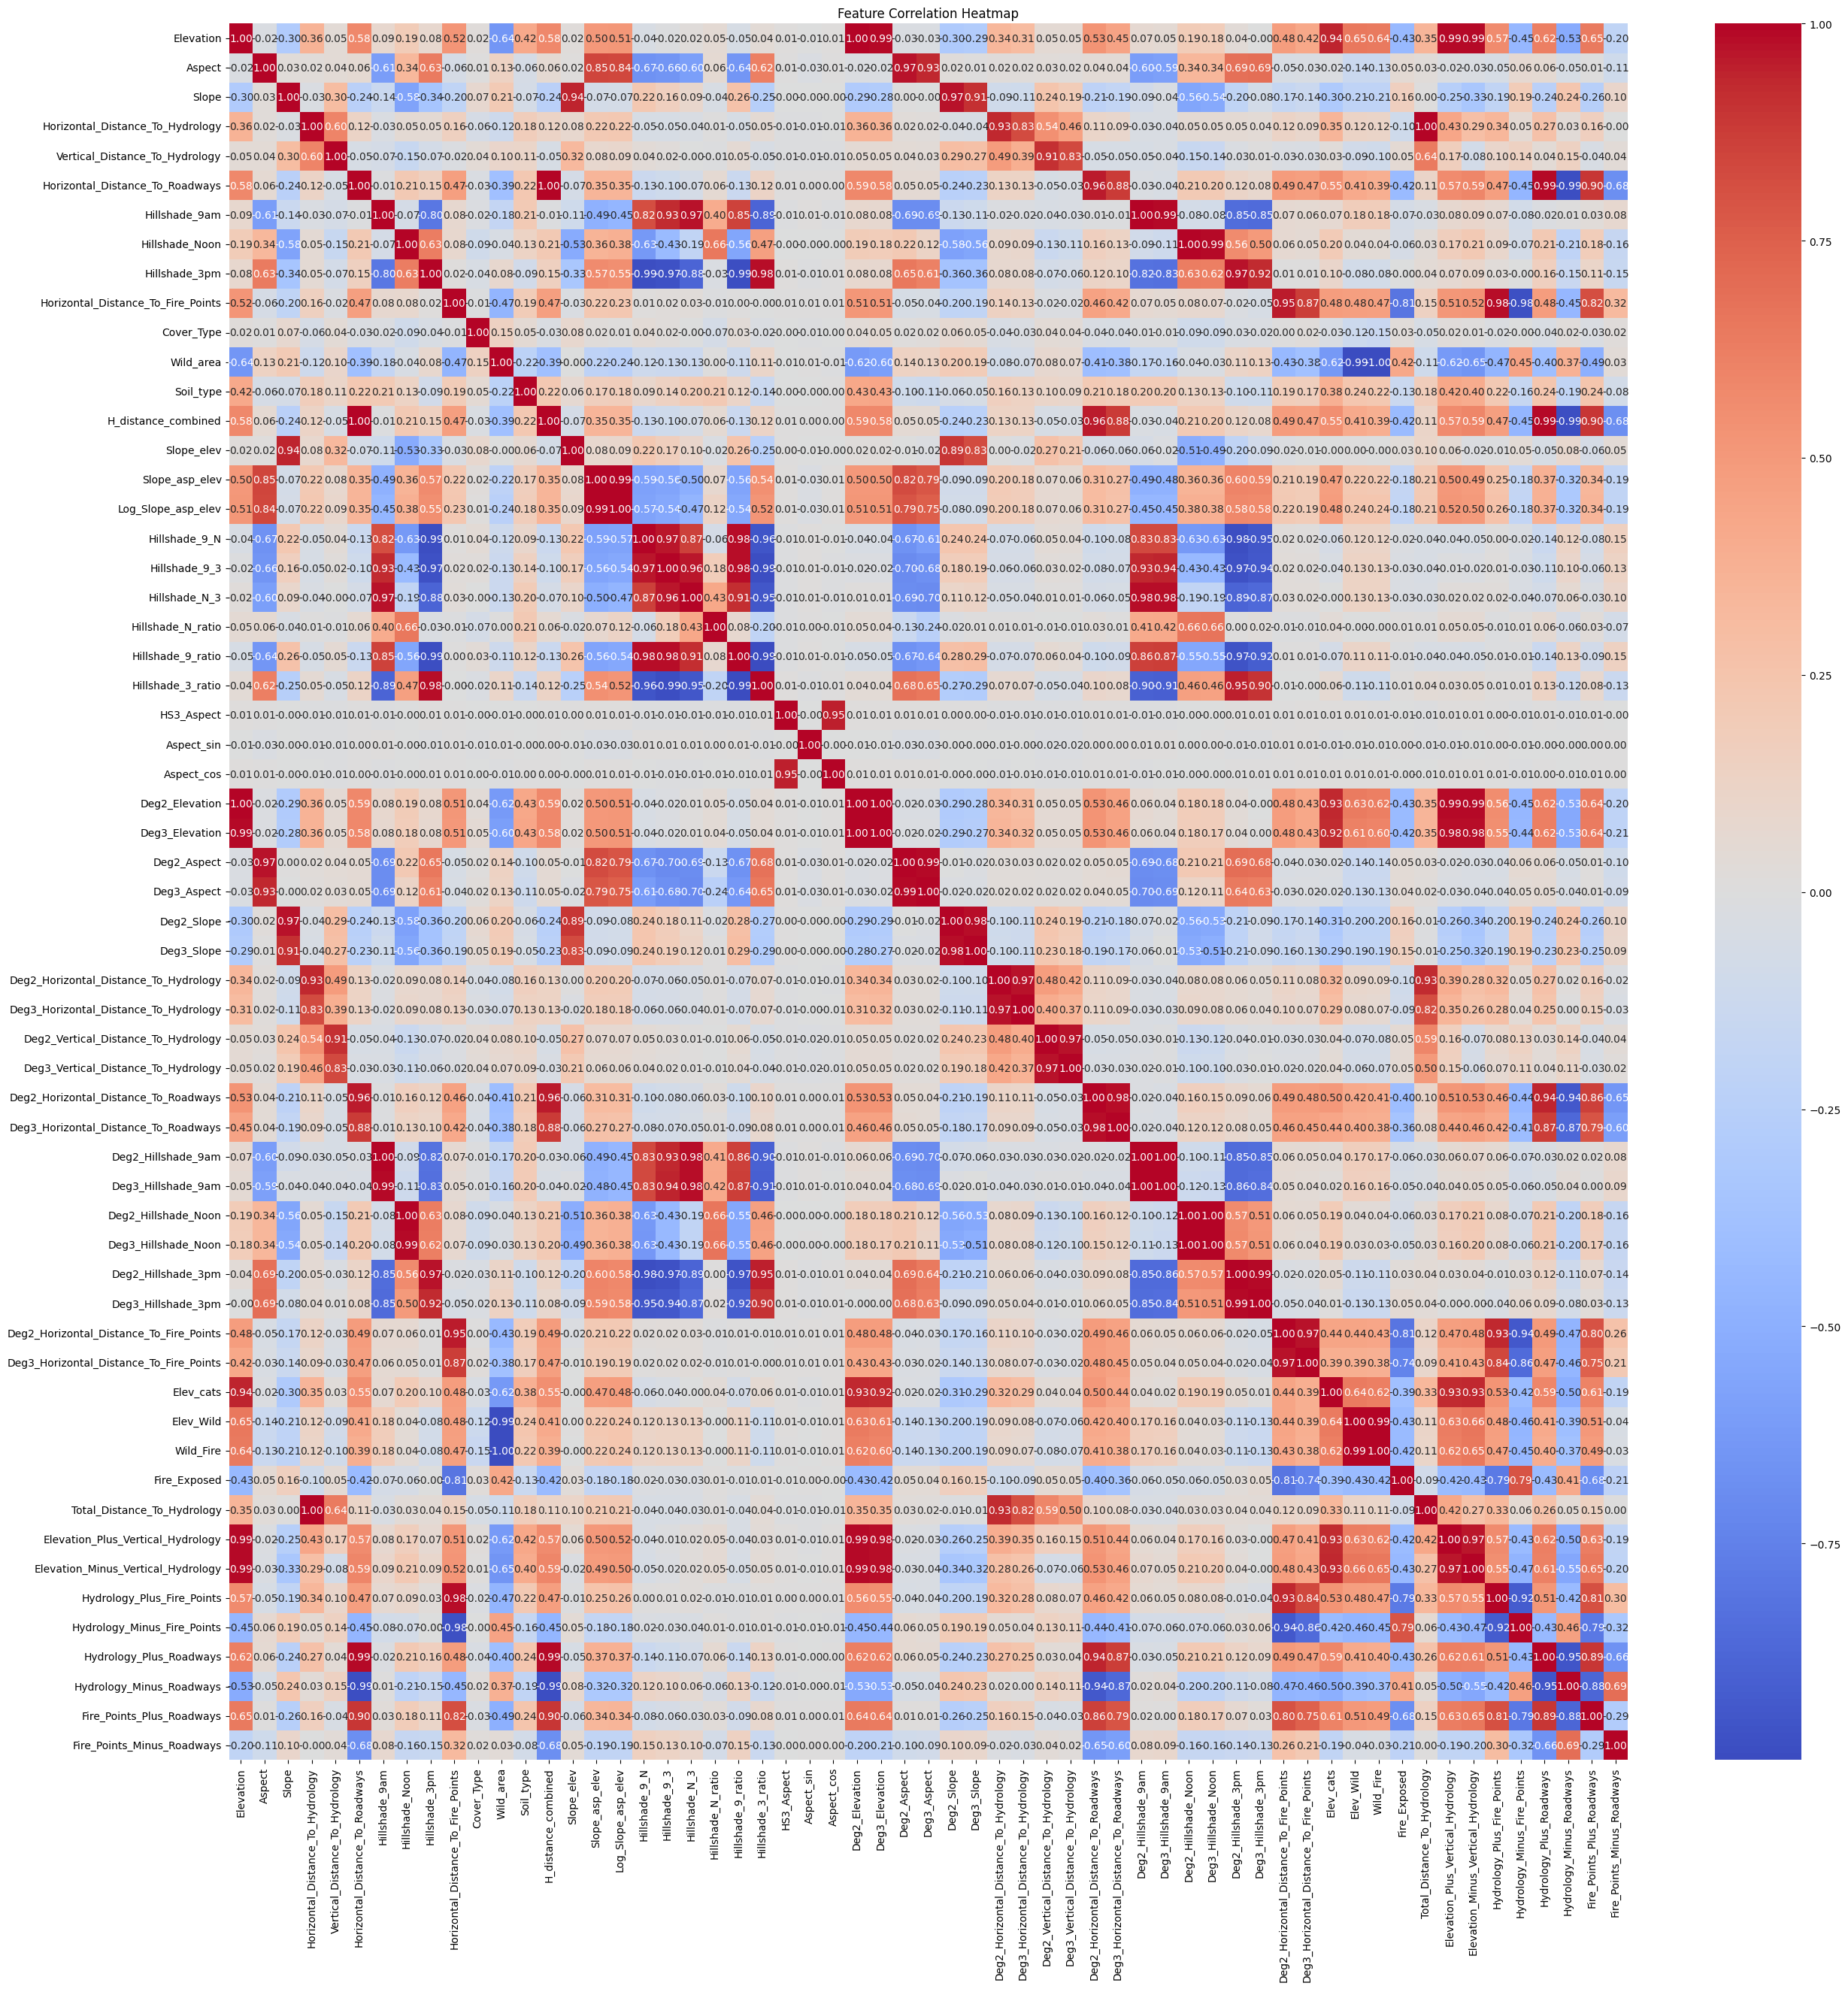

In [29]:
# Correlation matrix between features
plt.figure(figsize=(30, 30))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Final feature selection

The above created correlation matrix indicates very clearly that feature engineering introduced some heavy multicollinearity (especially for polynomial versions). In order to select the preferred features from these, I will apply the FI+MI combined score again and a Collinearity filtering method to keep only the most important one of these pairs.

In [30]:
# Calculate FI
X = train_data.drop(columns=["Cover_Type"])
y = train_data["Cover_Type"]

model = RandomForestClassifier(n_estimators=200, random_state=seed)
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
fi_df = pd.DataFrame({"Feature": X.columns[indices], "Importance": importances[indices]})

# Calculate MI
mi = mutual_info_classif(X, y, discrete_features=False)
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual_Information": mi})
mi_df = mi_df.sort_values("Mutual_Information", ascending=False)

# Combine FI and MI
scaler = MinMaxScaler()
fi_df["Normalized_FI"] = scaler.fit_transform(fi_df["Importance"].values.reshape(-1, 1))
mi_df["Normalized_MI"] = scaler.fit_transform(mi_df["Mutual_Information"].values.reshape(-1, 1))

combined_df = fi_df.set_index("Feature").join(mi_df.set_index("Feature")).drop(["Importance","Mutual_Information"],axis=1)
combined_df["Combined_Score"] = combined_df["Normalized_FI"] + combined_df["Normalized_MI"]
combined_df = combined_df.sort_values("Combined_Score", ascending=False)
combined_df

,Normalized_FI,Normalized_MI,Combined_Score
Feature,,,
Elevation_Minus_Vertical_Hydrology,1.000000,1.000000,2.000000
Deg2_Elevation,0.926641,0.891933,1.818574
Elevation,0.902635,0.891431,1.794067
Deg3_Elevation,0.863034,0.894179,1.757212
Elevation_Plus_Vertical_Hydrology,0.678739,0.802372,1.481111
Soil_type,0.540196,0.769718,1.309914
Elev_cats,0.308744,0.596734,0.905478
Wild_area,0.256523,0.416377,0.672900
Elev_Wild,0.175031,0.487751,0.662782


In [31]:
# First I filter out the variables not reaching the following impact threshold in Combined_Score.
impact_thd = 0.14
all_features = combined_df.index.tolist()
combined_df = combined_df.loc[combined_df.Combined_Score > impact_thd]
low_impact_features = [f for f in all_features if f not in combined_df.index.tolist()]
train_data.drop(columns=low_impact_features, inplace=True)
test_data.drop(columns=low_impact_features, inplace=True)
print(f"Number of variables changed: {len(all_features)}->{len(combined_df)}")

Number of variables changed: 58->44


Now I will keep only 1 from the same 'basename' features (as they are collinear e.g. Deg2_Elevation - Elevation).

In [32]:
def poly_filter(df):
    """ Keeping only the one with highest score from [original - degree 2 - degree 3] features. """
    feature_scores = df["Combined_Score"]
    feature_groups = {}

    for feature in feature_scores.index:
        base_name = re.sub(r"Deg[23]_", "", feature)
        if base_name not in feature_groups or feature_scores[feature] > feature_scores[feature_groups[base_name]]:
            feature_groups[base_name] = feature  # Keep the feature with the highest score

    return df.loc[feature_groups.values()]

filtered_df = poly_filter(combined_df)
before = len(combined_df)
after = len(filtered_df)
print(f"Number of variables changed: {before}->{after}")

train_keep = filtered_df.index.tolist() + ['Cover_Type']
test_keep = filtered_df.index.tolist()
train_data = train_data[train_keep]
test_data = test_data[test_keep]

Number of variables changed: 44->30


Finally, I also get rid of the low variance features, which would provide noise to the modelling part otherwise. 


In [33]:
# Remove low var features
print(f"Number of cols before (train): {len(train_data.columns)}")
print(f"Number of cols before (test): {len(test_data.columns)}");print()

threshold = 0.05
variances = train_data.drop(['Cover_Type'],axis=1).var()
sorted_variances = variances.sort_values()
low_variance_features = variances[variances < threshold].index.tolist()
train_data = train_data.drop(columns=low_variance_features)
test_data = test_data.drop(columns=low_variance_features)

print(f"Low var features are: {low_variance_features}");print()
print(f"Number of cols after (train): {len(train_data.columns)}")
print(f"Number of cols after (test): {len(test_data.columns)}")

Number of cols before (train): 31
Number of cols before (test): 30

Low var features are: ['Log_Slope_asp_elev', 'Hillshade_N_ratio', 'Hillshade_9_ratio', 'Hillshade_3_ratio']

Number of cols after (train): 27
Number of cols after (test): 26


In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13710 entries, 0 to 13709
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Elevation_Minus_Vertical_Hydrology       13710 non-null  int64  
 1   Deg2_Elevation                           13710 non-null  int64  
 2   Elevation_Plus_Vertical_Hydrology        13710 non-null  int64  
 3   Soil_type                                13710 non-null  int64  
 4   Elev_cats                                13710 non-null  int64  
 5   Wild_area                                13710 non-null  int64  
 6   Elev_Wild                                13710 non-null  int64  
 7   Wild_Fire                                13710 non-null  int64  
 8   Fire_Points_Plus_Roadways                13710 non-null  int64  
 9   Hydrology_Minus_Roadways                 13710 non-null  int64  
 10  Deg2_Horizontal_Distance_To_Roadways     13710

## Feature scaling & encoding

In [35]:
# Separating variables
cat_feats = ['Wild_Fire', 'Soil_type', 'Elev_cats', 'Wild_area', 'Elev_Wild'] 
# cat_feats = ['Wild_Fire', 'Soil_type', 'Elev_cats']
# cat_feats = ['Wild_Fire', 'Soil_type']

cont_feats = [c for c in train_data.columns if c not in cat_feats+["Cover_Type"]]

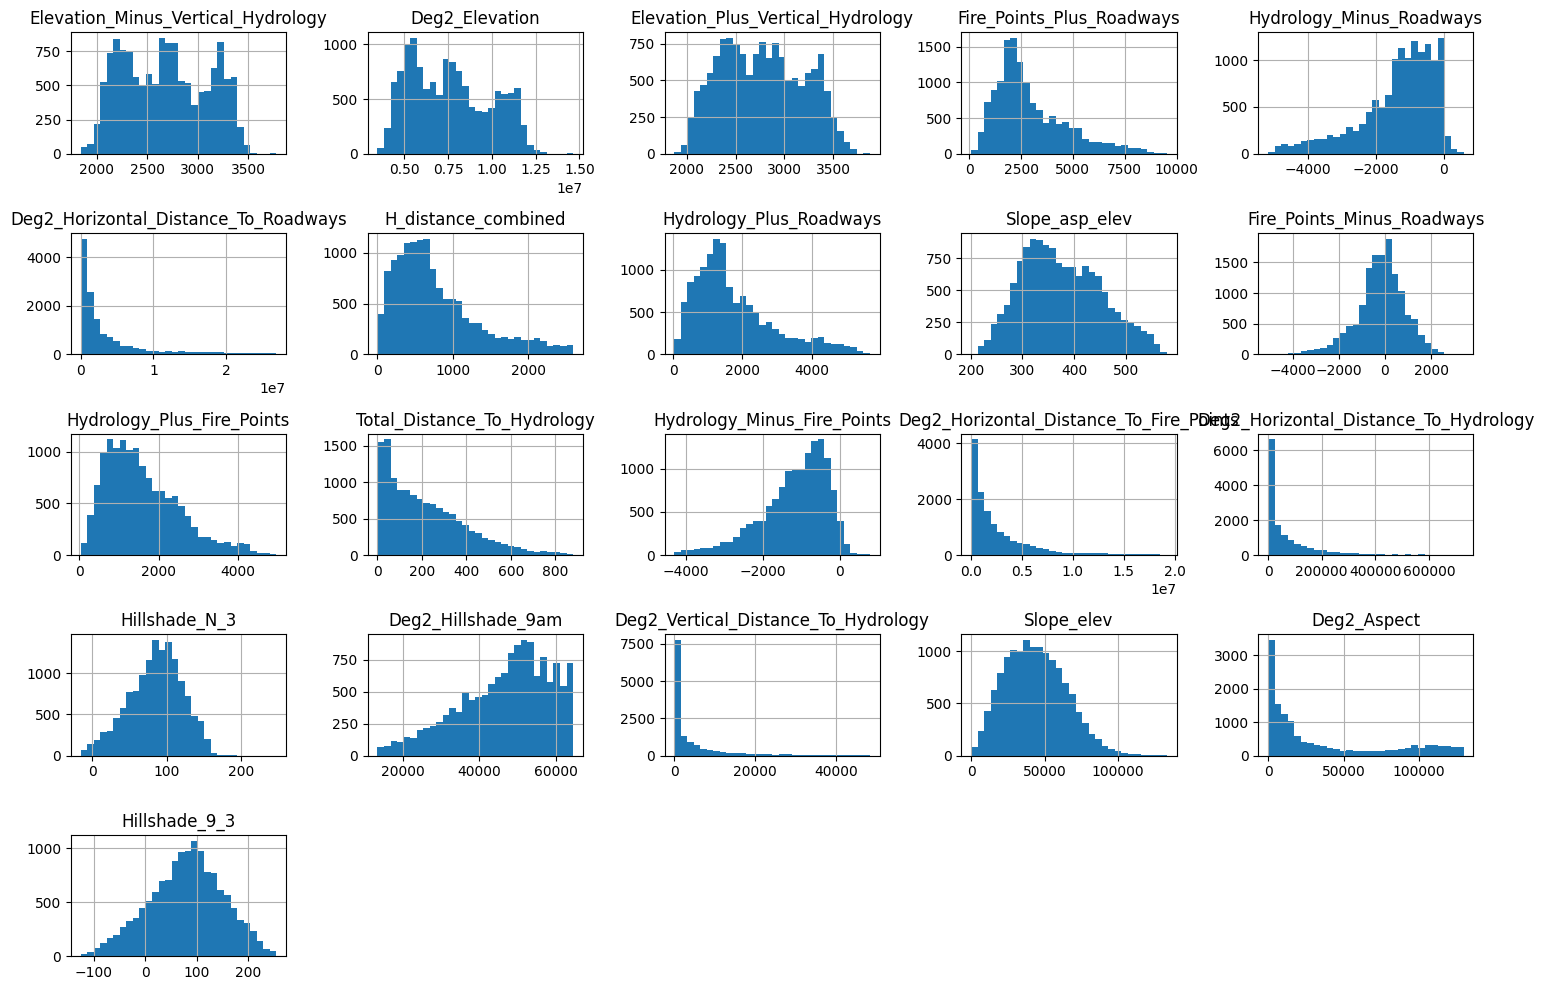

In [36]:
# Plot histograms for numerical features
train_data[cont_feats].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [37]:
# Standard scale continuous numerical features
from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()
train_data[cont_feats] = scaler_std.fit_transform(train_data[cont_feats])
test_data[cont_feats] = scaler_std.transform(test_data[cont_feats])

In [38]:
# One-hot encoding categoricals
train_data = pd.get_dummies(train_data, columns=cat_feats, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_feats, drop_first=True)
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

# Or label encoding?
# from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# le_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)  # Assign -1 to unknown values
# train_data[cat_feats] = le_encoder.fit_transform(train_data[cat_feats])
# test_data[cat_feats] = le_encoder.transform(test_data[cat_feats])

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13710 entries, 0 to 13709
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Elevation_Minus_Vertical_Hydrology       13710 non-null  float64
 1   Deg2_Elevation                           13710 non-null  float64
 2   Elevation_Plus_Vertical_Hydrology        13710 non-null  float64
 3   Fire_Points_Plus_Roadways                13710 non-null  float64
 4   Hydrology_Minus_Roadways                 13710 non-null  float64
 5   Deg2_Horizontal_Distance_To_Roadways     13710 non-null  float64
 6   H_distance_combined                      13710 non-null  float64
 7   Hydrology_Plus_Roadways                  13710 non-null  float64
 8   Slope_asp_elev                           13710 non-null  float64
 9   Fire_Points_Minus_Roadways               13710 non-null  float64
 10  Hydrology_Plus_Fire_Points               13710

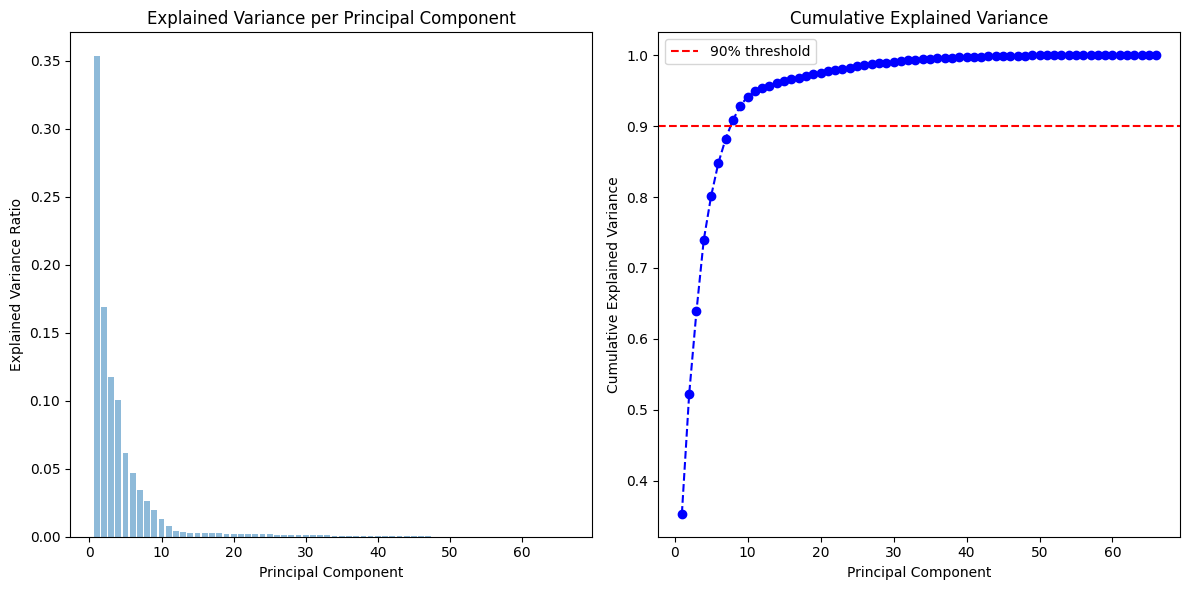


Number of components to retain 90% variance: 8


Variance ratio explained by principal components:
PC1: 0.3531 (35.31%)
PC2: 0.1688 (16.88%)
PC3: 0.1171 (11.71%)
PC4: 0.1006 (10.06%)
PC5: 0.0615 (6.15%)
PC6: 0.0469 (4.69%)
PC7: 0.0342 (3.42%)
PC8: 0.0266 (2.66%)


In [40]:
# PCA analysis
from sklearn.decomposition import PCA

# 1. Drop target from data to explore
features_reduced = train_data.drop(columns=['Cover_Type'], axis=1)

# 2. Apply PCA with all components, also plotting cumulative and explained variance
# Fit and transform the data with PCA
pca = PCA(n_components=None)  # Keeping all components to analyze explained variance
pca.fit(features_reduced)
pca_tr = pca.transform(features_reduced)

# Explained variance and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting explained variance and cumulative variance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance per Principal Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Reduce n_components to determine how many are the most descriptive ones (90% of variance)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\nNumber of components to retain 90% variance: {n_components}\n")

# 4. Apply PCA with selected number of components
pca = PCA(n_components=n_components)
features_pca_reduced = pca.fit_transform(features_reduced)

# 5. Get the explained variance ratio for each PC
explained_variance_ratio = pca.explained_variance_ratio_
print("\nVariance ratio explained by principal components:")
for i in range(n_components):
    pc = f'PC{i+1}'
    variance_ratio = explained_variance_ratio[i]
    print(f"{pc}: {variance_ratio:.4f} ({variance_ratio * 100:.2f}%)")

In [41]:
# train_data.shape, test_data.shape

In [42]:
# # Based on this, add given number of PCA to train and test set
# train_pca = pd.DataFrame(features_pca_reduced[:,:4], columns=["PCA1","PCA2","PCA3","PCA4"])

# pca = PCA(n_components=4)
# pca_test = pca.fit_transform(test_data.copy())
# test_pca = pd.DataFrame(pca_test[:,:4], columns=["PCA1","PCA2","PCA3","PCA4"])

# # Concatenate with datasets
# train_data = pd.concat([train_data.reset_index(drop=True), train_pca.reset_index(drop=True)], axis=1)
# test_data = pd.concat([test_data.reset_index(drop=True), test_pca.reset_index(drop=True)], axis=1)

In [43]:
# train_data.shape, test_data.shape

Adding PCA features didnt help in the end. Maybe different encoding or something else would solve it. 

## Modelling

In [44]:
import optuna
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)

In [45]:
# Split up the dataset
X, y = train_data.drop(['Cover_Type'], axis=1), train_data['Cover_Type']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=seed,
)

In [46]:
def print_results(best_clf, best_params, X_test, y_test, classifier_name, shift=False):
    y_pred = best_clf.predict(X_test)+1 if shift else best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    clf_rep = classification_report(y_test, y_pred)
    print(f"{classifier_name} - Best Parameters: {best_params}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.3f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{clf_rep}")
    print("*"*50)
    return y_pred

In [47]:
# Number of trials in study
N_TRIAL = 20

#### Random Forest

In [48]:
# Objective function for Optuna
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, step=100),
        'max_depth': trial.suggest_int('max_depth', 80, 180, step=20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10, step=1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        # 'class_weight': 'balanced',
    }
    model = RandomForestClassifier(**params, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train, sample_weight=sample_weights_train)
    y_prob = model.predict(X_test)
    acc = accuracy_score(y_test, y_prob)
    return acc

# Perform the hyperparameter optimization
start = datetime.now()
study = optuna.create_study(direction='maximize')  #Accuracy should be maximized
study.optimize(objective_rf, n_trials=N_TRIAL)
end = datetime.now()-start
print("Optuna study has finished.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# Best parameters
best_params_rf = study.best_params
print(f"Best Parameters: {best_params_rf}")

[I 2025-03-31 09:59:18,577] A new study created in memory with name: no-name-79c0de73-60a1-4f1d-8d7c-bf9a8abdc82d
[I 2025-03-31 09:59:23,995] Trial 0 finished with value: 0.8811086797957695 and parameters: {'n_estimators': 600, 'max_depth': 80, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.8811086797957695.
[I 2025-03-31 09:59:29,293] Trial 1 finished with value: 0.8358862144420132 and parameters: {'n_estimators': 700, 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8811086797957695.
[I 2025-03-31 09:59:32,731] Trial 2 finished with value: 0.8570386579139314 and parameters: {'n_estimators': 300, 'max_depth': 100, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8811086797957695.
[I 2025-03-31 09:59:36,333] Trial 3 finished with value: 0.838439095550693 and parameters: {'n_estimators': 400, 'max_depth': 180,

Optuna study has finished.
 - time spent (hh:mm:ss:ms): 0:01:30.430768
Best Parameters: {'n_estimators': 600, 'max_depth': 80, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}


#### Extratrees

In [49]:
def objective_extratrees(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, step=100),
        'max_depth': trial.suggest_int('max_depth', 30, 180, step=10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20, step=2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10, step=1),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'criterion': trial.suggest_categorical('criterion', ['entropy', 'gini']),
    }
    model = ExtraTreesClassifier(**params, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train, sample_weight=sample_weights_train)
    y_prob = model.predict(X_test)
    acc = accuracy_score(y_test, y_prob)
    return acc

# Perform the hyperparameter optimization
start = datetime.now()
study = optuna.create_study(direction='maximize')  #Accuracy should be maximized
study.optimize(objective_extratrees, n_trials=N_TRIAL)
end = datetime.now()-start
print("Optuna study has finished.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# Best parameters
best_params_et = study.best_params
print(f"Best Parameters: {best_params_et}")

[I 2025-03-31 10:00:49,304] A new study created in memory with name: no-name-b81fa793-4606-4016-ab69-bfc113871dda
[I 2025-03-31 10:00:50,836] Trial 0 finished with value: 0.8212983223924143 and parameters: {'n_estimators': 400, 'max_depth': 130, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8212983223924143.
[I 2025-03-31 10:00:52,465] Trial 1 finished with value: 0.812545587162655 and parameters: {'n_estimators': 400, 'max_depth': 140, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8212983223924143.
[I 2025-03-31 10:00:55,118] Trial 2 finished with value: 0.8092633114514952 and parameters: {'n_estimators': 700, 'max_depth': 60, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8212983223924143.
[I 2025-03-31 10:00:57,307] Trial 3 finished with value: 0

Optuna study has finished.
 - time spent (hh:mm:ss:ms): 0:00:37.868377
Best Parameters: {'n_estimators': 300, 'max_depth': 160, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}


#### XGBoost

In [50]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'max_depth': trial.suggest_int('max_depth', 30, 180, step=10),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20, step=2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1, step=0.1), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1, step=0.1), # L2 regularization
        'subsample': trial.suggest_float('subsample', 0.6, 1, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1, step=0.1), # feature set subsampling
        'gamma': trial.suggest_float('gamma', 0, 5, step=0.5), # Regularization for split selection
        'device': 'cuda',
        'tree_method': 'gpu_hist',
    }
    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='mlogloss', random_state=seed)
    y_train_shifted = np.array(y_train) - 1 # XGB expects [0 1 2 3 4 5 6]
    model.fit(X_train, y_train_shifted, sample_weight=sample_weights_train)
    y_prob = model.predict(X_test) + 1
    acc = accuracy_score(y_test, y_prob)
    return acc

# Perform the hyperparameter optimization
start = datetime.now()
study = optuna.create_study(direction='maximize')  #Accuracy should be maximized
study.optimize(objective_xgb, n_trials=N_TRIAL)
end = datetime.now()-start
print("Optuna study has finished.")
print(f" - time spent (hh:mm:ss:ms): {end}")

# Best parameters
best_params_xgb = study.best_params
print(f"Best Parameters: {best_params_xgb}")

[I 2025-03-31 10:01:27,473] A new study created in memory with name: no-name-fe780722-4e8b-440a-b9cb-1444b027c98b
[I 2025-03-31 10:01:31,051] Trial 0 finished with value: 0.7913931436907367 and parameters: {'n_estimators': 600, 'learning_rate': 0.13647733095371317, 'max_depth': 40, 'min_child_weight': 6, 'reg_alpha': 0.0, 'reg_lambda': 0.5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 4.5}. Best is trial 0 with value: 0.7913931436907367.
[I 2025-03-31 10:01:33,364] Trial 1 finished with value: 0.7720641867250182 and parameters: {'n_estimators': 500, 'learning_rate': 0.7215236747274686, 'max_depth': 140, 'min_child_weight': 6, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.2, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5.0}. Best is trial 0 with value: 0.7913931436907367.
[I 2025-03-31 10:01:36,072] Trial 2 finished with value: 0.799416484318016 and parameters: {'n_estimators': 500, 'learning_rate': 0.18102048953842387, 'max_depth': 70, 'min_child_weight': 10, 'reg_alp

Optuna study has finished.
 - time spent (hh:mm:ss:ms): 0:01:38.244530
Best Parameters: {'n_estimators': 400, 'learning_rate': 0.049254880252462635, 'max_depth': 120, 'min_child_weight': 16, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.0, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.5}


#### CatBoost

In [51]:
# from catboost import CatBoostClassifier

# start = datetime.now()
# params = {"depth":12, "iterations":2000, "learning_rate":0.1, "l2_leaf_reg":3, "task_type":"GPU", "verbose":200}
# cat_model = CatBoostClassifier(**params)
# cat_model.fit(X_train, y_train)
# end = datetime.now()-start
# print("CatBoost finished training.")
# print(f" - time spent (hh:mm:ss:ms): {end}\n")

# cat_pred = print_results(cat_model, params, X_test, y_test, "CatBoost")

In [52]:
# Stacking classifier
cat_params = {"depth":12, "iterations":2000, "learning_rate":0.1, "l2_leaf_reg":3, "task_type":"GPU", "devices":"0", "thread_count":1, "verbose":200}
base_learners = [
    ('rf', RandomForestClassifier(**best_params_rf, random_state=seed, n_jobs=-1)),
    ('et', ExtraTreesClassifier(**best_params_et, random_state=seed, n_jobs=-1)),
    ('xgb', XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='mlogloss', random_state=seed)),
    ('cat', CatBoostClassifier(**cat_params))
]

# Train meta-learner
meta_learner = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state=seed)
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=3, n_jobs=1)
stacking_clf.fit(X_train, y_train, sample_weight=sample_weights_train)

# Make final predictions and evaluate
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Stacking Classifier: {accuracy:.4f}")

0:	learn: 1.7580546	total: 421ms	remaining: 14m
200:	learn: 0.1424701	total: 20.9s	remaining: 3m 7s
400:	learn: 0.0747032	total: 41.3s	remaining: 2m 44s
600:	learn: 0.0497286	total: 1m 1s	remaining: 2m 23s
800:	learn: 0.0371793	total: 1m 22s	remaining: 2m 3s
1000:	learn: 0.0293318	total: 1m 42s	remaining: 1m 42s
1200:	learn: 0.0240308	total: 2m 3s	remaining: 1m 21s
1400:	learn: 0.0202977	total: 2m 23s	remaining: 1m 1s
1600:	learn: 0.0174169	total: 2m 43s	remaining: 40.8s
1800:	learn: 0.0152994	total: 3m 3s	remaining: 20.3s
1999:	learn: 0.0136276	total: 3m 24s	remaining: 0us
0:	learn: 1.8007148	total: 217ms	remaining: 7m 14s
200:	learn: 0.1323802	total: 20.7s	remaining: 3m 5s
400:	learn: 0.0709175	total: 40.8s	remaining: 2m 42s
600:	learn: 0.0473091	total: 1m	remaining: 2m 21s
800:	learn: 0.0349467	total: 1m 21s	remaining: 2m 1s
1000:	learn: 0.0274714	total: 1m 40s	remaining: 1m 40s
1200:	learn: 0.0226952	total: 2m	remaining: 1m 20s
1400:	learn: 0.0190330	total: 2m 20s	remaining: 1m
160

## Submission

In [53]:
X_test.shape, test_data.shape

((2742, 66), (565892, 67))

In [54]:
test_pred = stacking_clf.predict(test_data.drop('Cover_Type', axis=1))

In [55]:
# Make submission
Id = np.asarray(pd.read_csv('/kaggle/input/forest-cover-type-prediction/test.csv')['Id'])
predictions = pd.DataFrame({'Id': Id, 'Cover_Type': test_pred})
predictions.to_csv('submission.csv', header=True, index=False)
predictions.head(10)

,Id,Cover_Type
0,15121,2
1,15122,2
2,15123,2
3,15124,2
4,15125,2
5,15126,2
6,15127,2
7,15128,2
8,15129,2
9,15130,2
